<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
pd.set_option("mode.copy_on_write", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h1>Calculating Pressure Variation for a Single Station</h1>

We saw in a previous notebook (01_initial_data_check) how the data provided by meteostat is structured, and in another (02_outlier_check) how we might identify outliers, so we're now ready to move on to some real analysis. 

It's at this point that we should consider what our goals are, and create a rough plan to take us from the initial raw data to a deliverable of some kind, or another important intermediate state.

This project is concerned with the role of weather variation in triggering migraine attacks, with the ultimate goal to produce a map (or series of maps) with locations colour-coded according to their associated weather migraine risk. In effect, a map of the best and worst places to live if you have weather-induced migraine. 

In creating this map, we first need to identify what weather patterns constitute a "risk", create and calculate a series of variables that can represent this "risk", then map the results for many stations.

For the first point, this is actually quite difficult to quantify with relatively few studies available. However, increased risk of migraine has been found to be associated with warmer, humid days ([Elcik et al. 2017](https://pubmed.ncbi.nlm.nih.gov/28900742/)), drops in barometric air pressure ([Okuma et al. 2015](https://pmc.ncbi.nlm.nih.gov/articles/PMC4684554/)), and storm activity ([Martin et al. 2013](https://journals.sagepub.com/doi/full/10.1177/0333102412474502)). 

To begin with, we'll look at barometric air pressure and how we can quantify changes in this variable for a single weather station.

First, we need to select a station. This time, I'm going to look for stations around London, within a 90km radius (roughly the London Metropolitan Area), that have hourly weather data covering a period of at least [1995, 2020].

In [3]:
import meteostat

stations = meteostat.Stations().nearby(51.5072, -0.1257, 90000).fetch()
stations = stations[(~stations["hourly_start"].isnull()) & (~stations["hourly_end"].isnull())]
stations = stations[(stations["hourly_start"].dt.year <= 1995) & (stations["hourly_end"].dt.year >= 2020)]
stations

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end,distance
id,,,,,,,,,,,,,,,,
EGLC0,London / Abbey Wood,GB,ENG,<NA>,EGLC,51.5000,0.1167,5.0,Europe/London,1988-01-29,2024-12-03,2007-09-26,2022-04-27,2016-01-01,2022-01-01,16796.799477
03672,Northolt,GB,ENG,03672,EGWU,51.5500,-0.4167,38.0,Europe/London,1973-01-01,2024-12-03,1973-01-05,2022-04-25,2005-01-01,2022-01-01,20685.414510
03772,London Heathrow Airport,GB,ENG,03772,EGLL,51.4833,-0.4500,24.0,Europe/London,1948-12-01,2024-12-03,1948-12-01,2024-11-30,1948-01-01,2022-01-01,22607.264285
EGKB0,Biggin Hill / berry's green,GB,ENG,<NA>,EGKB,51.3167,0.0333,183.0,Europe/London,1988-01-05,2024-12-02,2020-01-14,2022-04-26,2020-01-01,2022-01-01,23881.053833
03776,London Gatwick Airport,GB,ENG,03776,EGKK,51.1500,-0.1833,62.0,Europe/London,1973-01-01,2024-12-03,1973-01-02,2022-04-25,1961-01-01,2022-01-01,39919.939853
03673,London / Chiltern Green / Newmill End / Stopsl...,GB,ENG,03673,EGGW,51.8667,-0.3667,160.0,Europe/London,1988-01-05,2024-12-03,1988-01-31,2022-04-25,2009-01-01,2022-01-01,43289.414407
03763,Bracknell / Beaufort Park,GB,ENG,03763,EGRR,51.3833,-0.7833,74.0,Europe/London,1973-01-01,2023-01-31,1992-03-30,2003-09-19,NaT,NaT,47610.733626
03683,Stansted Airport,GB,ENG,03683,EGSS,51.8833,0.2333,106.0,Europe/London,1973-01-01,2024-12-03,1973-01-05,2022-04-25,1981-01-01,2022-01-01,48591.931127
03768,Farnborough,GB,ENG,03768,EGLF,51.2833,-0.7667,65.0,Europe/London,1988-05-01,2024-12-03,1988-05-02,2022-04-25,2005-01-01,2022-01-01,50966.557365


We have 15 stations all with very good data coverage! I'm going to pick **London Heathrow Airport**.

With a station selected, we can now retrieve the actual pressure data for a given timeframe. Before we can look at true variations, though, we need to remove some outliers following the method from notebook 02. Using 1.5IQR as our outlier boundary tends to flag legitimate instances of highly variable data, which may introduce a bias as our final goal is to count days of high variation. So instead, I am increasing the IQR rejection range to +/- 3IQR and additionally am going to require that a day has at least two instances of crossing this boundary (as a spike should give two high variations in sequence).

In [4]:
from datetime import datetime
import pandas as pd

heathrow_loc = stations[stations['name']=="London Heathrow Airport"]
start = datetime(heathrow_loc["hourly_start"][0].year, heathrow_loc["hourly_start"][0].month, heathrow_loc["hourly_start"][0].day, 0, 0, 0)
end = datetime(heathrow_loc["hourly_end"][0].year, heathrow_loc["hourly_end"][0].month, heathrow_loc["hourly_end"][0].day, 23, 59, 59)

df = meteostat.Hourly(heathrow_loc, start, end).fetch()

# calculate dvar_per_hour
vars = ["temp","rhum","prcp","wspd","pres"]
dt = df.index.to_series().diff().dt.days*24. + df.index.to_series().diff().dt.seconds//3600

cleaned_df = df.copy()
for var in vars:
    df[f'd{var}_per_hour'] = df[f'{var}'].diff() / dt
    
    # determine IQR for dvar_per_hour
    statistics = df[f'd{var}_per_hour'].describe()
    q75 = statistics["75%"]
    q25 = statistics["25%"]
    intr_qr = q75 - q25
    maxq = q75 + (3*intr_qr)
    minq = q25 - (3*intr_qr)
    
    # Find outliers with >=2 variations outside 3 IQR
    outliers = df[(df[f'd{var}_per_hour'] < minq) | (df[f'd{var}_per_hour'] > maxq)];
    outliers['date'] = outliers.index.date;
    entry_counts = outliers['date'].value_counts();
    valid_dates = entry_counts[entry_counts > 1].index;
    outliers = outliers[outliers['date'].isin(valid_dates)];
    
    # drop outlier days from dataframe
    drop_dates = list(set(outliers.index.date))
    cleaned_df = cleaned_df[~pd.Series(cleaned_df.index.date).isin(drop_dates).values]

With at least some of the outliers removed, we can now look at the number of days with absolute variations above a certain risk threshold:

In [206]:
fdays_yearly = {}
# loop over years
for yname, ygroup in cleaned_df.groupby(pd.Grouper(freq='YE')):
    if ygroup["pres"].isna().all():
        fdays_yearly[yname.year] = float('nan')
        continue
    if sum(ygroup["pres"].isna())>0.1*len(ygroup["pres"]):
        fdays_yearly[yname.year] = float('nan')
        continue
        
    ndays = 0
    # loop over days
    for dname, dgroup in ygroup.groupby(pd.Grouper(freq='D')):
        prange = dgroup["pres"].max() - dgroup["pres"].min()
        if prange >= 10.:
            ndays += 1
    
    frac_days = ndays/len(list(set(ygroup.index.date)))
    fdays_yearly[yname.year] = frac_days

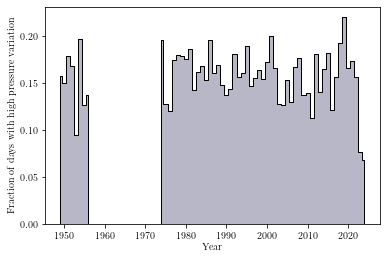

In [208]:
import matplotlib.pyplot as plt

x = list(fdays_yearly.keys())
z = list(fdays_yearly.values())
plt.fill_between(x, 0, z, step='mid', facecolor=(0.3, 0.3, 0.45 ,.4), edgecolor=(0, 0, 0, 1))
plt.ylim(0);
plt.xlabel("Year");
plt.ylabel("Fraction of days with high pressure variation");

So there we have it! The number of days per year that featured a pressure variation of >=10hPa at London Heathrow Airport between the years 1948 and 2024. In the next notebook, we'll look to expand this to cover multiple stations in an area to produce maps.